In [32]:
import math
import random
from graphviz import Digraph

In [33]:
class Value:
    def __init__(self, data, children=(), operation='', label=''):
        self.data = data
        self.label = label
        self.prev = children
        self.operation = operation
        self.grad = 0.0
        self.backward = lambda : None

    def __repr__(self):
        return f'Value(data={self.data})'

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out.backward = _backward
        return out

    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out.backward = _backward
        return out
    
    def __truediv__(self, other):
        return self * other**-1

    def __pow__(self, other):
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data**(other - 1)) * out.grad
        out.backward = _backward

        return out

    def __radd__(self, other):
        return self + other
    
    def __rmul__(self, other):
        return self * other

    def __neg__(self):
        return self * -1
    
    def tanh(self):
        out = Value(math.tanh(self.data), (self, ), 'tanh')

        def _backward():
            self.grad += (1 - math.tanh(self.data)**2) * out.grad
        out.backward = _backward

        return out
    
    def top_backward(self):
        self.grad = 1.0

        def backward_recursion(parent_node):
            parent_node.backward()
            for node in parent_node.prev:
                backward_recursion(node)
        
        backward_recursion(self)


In [34]:
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v.prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n.operation:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n.operation, label = n.operation)
      # and connect this node to it
      dot.edge(uid + n.operation, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2.operation)

  return dot

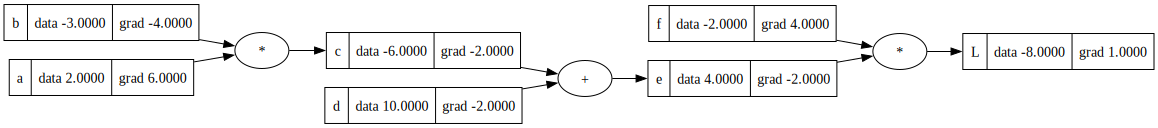

In [35]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
d = Value (10.0, label='d')
f = Value (-2.0, label='f')

c = a * b; c.label='c'
e = c + d; e.label='e'
L = e * f; L.label='L'
L.top_backward()
draw_dot(L)

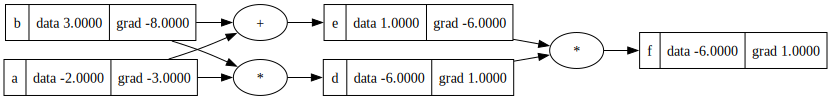

In [36]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.top_backward()

draw_dot(f)

In [37]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.top_backward()

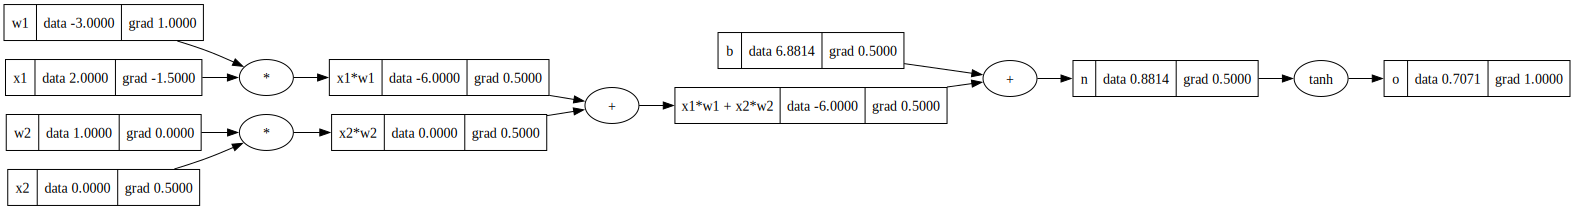

In [38]:
draw_dot(o)

In [39]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        activation = sum( xi*wi for xi, wi in zip(x, self.w)) + self.b
        return activation.tanh()
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outputs = [neuron(x) for neuron in self.neurons]
        return outputs[0] if len(outputs) == 1 else outputs
    
    def parameters(self):
        return [parameters for neuron in self.neurons for parameters in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        mlp = [nin] + nouts
        self.layers = [Layer(mlp[n], mlp[n+1]) for n in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [parameters for layer in self.layers for parameters in layer.parameters()]

In [40]:
nn = MLP(3, [4, 4, 1])

In [41]:
def describe_mlp(nn):
    for i, layer in enumerate(nn.layers):
        print('layer: ', i + 1)
        for ni, neuron in enumerate(layer.neurons):
            print('neuron', ni + 1)
            for wi, w in enumerate(neuron.w):
                print(f'w{wi + 1}: {w.data}')
            print(f'b: {neuron.b.data}')
        print('')

In [42]:
describe_mlp(nn)

layer:  1
neuron 1
w1: 0.8901384153232812
w2: -0.7477220434814149
w3: 0.5940367563908546
b: -0.424417985411345
neuron 2
w1: -0.8142985035785526
w2: -0.872381452311277
w3: -0.3874891544110357
b: -0.30321230154552103
neuron 3
w1: 0.7527452182016203
w2: 0.16214308096877006
w3: 0.4127708987807899
b: 0.12212937580487537
neuron 4
w1: -0.9431900966858615
w2: 0.2659364303883558
w3: 0.5544792011878408
b: -0.7945878993469175

layer:  2
neuron 1
w1: -0.5394145288981684
w2: 0.35578515793526955
w3: 0.3388621098930398
w4: -0.8616356441900599
b: 0.9782506761663756
neuron 2
w1: -0.6927155689330102
w2: -0.6730639269709615
w3: 0.24638492393555445
w4: 0.5674595340383852
b: 0.15028551049301098
neuron 3
w1: 0.8800690167599021
w2: -0.21975000741007866
w3: 0.8546112165265614
w4: -0.709576952706404
b: -0.24613854868920626
neuron 4
w1: 0.7865869344945227
w2: -0.7728001281244594
w3: -0.19949083014133784
w4: 0.46241811443034364
b: 0.4386520406148062

layer:  3
neuron 1
w1: 0.3951579297333887
w2: -0.5178421578481

In [43]:
inputs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0]
]
desired_outputs = [1.0, -1.0, -1.0, 1.0]


In [44]:
for i in range(3000):
    h = 0
    if i <= 1000:
        h = 0.1
    elif i <= 2000:
        h = 0.05
    else:
        h = 0.01

    predicted_values = [nn(x) for x in inputs]

    loss = sum([(predicted-desired)**2 for desired, predicted in zip(desired_outputs, predicted_values)])

    for p in nn.parameters():
        p.grad = 0
    loss.top_backward()

    for p in nn.parameters():
        p.data += -0.1 * p.grad
  
    print(i, loss.data)

0 7.195316432768635
1 1.7484521339736196
2 3.7493879716180913
3 4.96677711288291
4 2.7496584747645656
5 0.24047594521115506
6 0.12893668785414183
7 0.0903937475884106
8 0.06967749441999616
9 0.056690559164071716
10 0.0477775986186758
11 0.04127978713199389
12 0.03633260398285494
13 0.032440509328737
14 0.029298860463824832
15 0.02670999818490301
16 0.0245400549612077
17 0.022695136812423793
18 0.021107439461301825
19 0.019726776644405468
20 0.018515208519145322
21 0.017443522423124486
22 0.016488861148792465
23 0.01563308467302085
24 0.014861613687719457
25 0.014162597355773562
26 0.013526303988672526
27 0.012944667970536294
28 0.012410948109811247
29 0.011919466713165624
30 0.011465407978960519
31 0.01104466055549945
32 0.010653693377583987
33 0.010289456856880864
34 0.009949303586859642
35 0.009630924210737432
36 0.009332295175359297
37 0.009051635878938268
38 0.008787373300209421
39 0.008538112628828122
40 0.008302612742233314
41 0.008079765621283394
42 0.00786857898614118
43 0.0076

In [45]:
predicted_values = [nn(x) for x in inputs]
predicted_values

[Value(data=0.9948996004460571),
 Value(data=-0.9959585658795947),
 Value(data=-0.9945620179774713),
 Value(data=0.9948985284673124)]

In [46]:
describe_mlp(nn)

layer:  1
neuron 1
w1: 0.8841683774803256
w2: -0.48649315135010124
w3: 4.149808853969347
b: -0.1705910775904159
neuron 2
w1: 2.56091543038589
w2: 2.283757297604958
w3: -3.0571559733365916
b: 0.17190720535888107
neuron 3
w1: 6.301832989206449
w2: 2.260548605445084
w3: 0.807769726795622
b: 0.9445650615721077
neuron 4
w1: 16.11444385167374
w2: -3.683004541870444
w3: 4.5186979897190565
b: 0.1234433560460346

layer:  2
neuron 1
w1: -1.2637041048973068
w2: 0.17850646771808246
w3: 0.13164196840250836
w4: -0.9008566529479834
b: 0.8228673641389371
neuron 2
w1: -0.5293478991888568
w2: -0.769920726960537
w3: 0.40110381913261806
w4: 0.5490528807467517
b: 0.1871297036338531
neuron 3
w1: 1.534795576552616
w2: -0.12729225212691683
w3: 0.971394359994198
w4: -0.5077100969562386
b: -0.39953286151508755
neuron 4
w1: 0.11419900686130106
w2: -0.9446568859879368
w3: -0.0959116204774282
w4: 0.2838432136438733
b: 0.6856155703876698

layer:  3
neuron 1
w1: 1.3544435485044632
w2: 0.3440550420520227
w3: -1.96115